# Strip Detector

this notebook loads data acquired with a segmented silicon detector

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mp
import copy
import re

shot_no = 0


Download logfile and time of plasma start and plasma end

In [4]:
log_URL = "http://golem.fjfi.cvut.cz/shots/{}/Diagnostics/StripDetector/PH32.log"
plasma_URL = "http://golem.fjfi.cvut.cz/shots/{}/Diagnostics/BasicDiagnostics/Results/{}"

ds = np.DataSource(None)

logfile = ds.open(log_URL.format(shot_no))
#logfile = ds.open("PH32.log")
t_plasma_start = ds.open(plasma_URL.format(shot_no, "t_plasma_start"))
t_plasma_start = np.loadtxt(t_plasma_start)

t_plasma_end = ds.open(plasma_URL.format(shot_no, "t_plasma_end"))
t_plasma_end = np.loadtxt(t_plasma_end)

### Reading log file

Communication between rPi (or any other computer) and [PH32 readout chip](http://hdl.handle.net/10467/86873) is achieved with SURE (Simple USB Readout Equipment).

SURE uses [NMEA 0183](https://en.wikipedia.org/wiki/NMEA_0183) protocol for communication. Each message for configuring PH32 is acknowledged. These 'echos' are saved in the log file.   
For example `$ACKNL,SEATM -- acquisition time set to 100us*1b` is response to `$SEATM,100` command which sets acquisition time.   
`$STARB,[wait-for-trigger],[delay]` sets detector for measurement and is fololowed by 200 frames of measured data eg.: 
`$FRAME,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0*5d`

From log file we extract 
+ acquisition time of one frame
+ delay between frames
+ acquisition mode 
    - hit count
    - ToT = Time over threshold $\sim$ deposited energy
    - first hit $\sim$ deposited energy of first detected particle
    - ToA = Time of Arrival (for time of flight measeruement, not useful for in our context)

+ frames
    - for each strip, we get a value in the range 0-65534. Depending on the acquisition mode, this represents
        - number of hist
        - number of clock cycles
        - value 65535 is used in case of overflow, channel saturation, or when a channel is disabled

In [5]:
frames = []

# defaults
acc_time    = 0.15 #ms
delay       = 0.10 #ms
start_delay = 0.50 #ms
acc_mode = 'hit count'

# read logfile
for line in logfile:
    regex_seatm = re.match("\$ACKNL,SEATM -- acquisition time set to (\d+)us", line)
    if regex_seatm:
        acc_time = regex_seatm.group(1) 
        acc_time = int(acc_time)/1000.0 ## ms
            
    regex_delay = re.match("\$ACKNL,DELAY -- delay set to (\d+)us", line)
    if regex_delay:
        delay = regex_delay.group(1)
        delay = int(delay)/1000.0 ## ms
            
    regex_selo1= re.match(
        "\$ACKNL,SELO1 -- local configuration for channel (\d+) was set to value (\d+)", line)
    if regex_selo1 and ( int(regex_selo1.group(2)) & 0x40):
        acc_mode = "ToT"
    elif regex_selo1 and ( int(regex_selo1.group(2)) & 0x20):
        acc_mode = "first hit"
    elif regex_selo1 and ( int(regex_selo1.group(2)) & 0x60):
        acc_mode = "ToA"
    elif regex_selo1:
        acc_mode = "hit count"
            
    regex_startb = re.match("\$STARB,(\d+),(\d+)", line)
    if regex_startb:
        start_delay = regex_startb.group(2)
        start_delay = int(start_delay)/1000.0 ## ms
                        

    regex_frame = re.match("\$FRAME,((?:\d+,)+)(\d+)\*[0-9a-f]{2}", line)
    if regex_frame:
        line = np.fromstring(''.join(regex_frame.groups()), sep=',')
        ### saturation or error in measeurement or chanel is disabled
        line[line == 65535] = -1 
        frames.append(line)
            
frames = np.array(frames)

#### Plot raw data


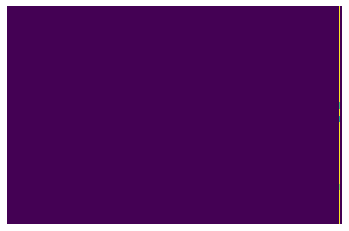

In [6]:
plt.pcolormesh(frames.T);
plt.axis('off')
plt.savefig('rawdata.png')

### Rearrange channels

The order of channels on the PH32 chip does not correspond to the order of strips on the sensor; we need to rearrange them.  
Strip n. 0 is on channel 15, strip n. 1 on channel 16, ... 

In [7]:
channelOrder = [15,16,14,17,13,18,12,19,11,20,10,21,9,22,8,23,24,7,25,6,26,5,27,4,28,3,29,2,30,1,31,0]

permutation_matrix = np.zeros((len(channelOrder), len(channelOrder)))
for idx, i in enumerate(channelOrder):
    permutation_matrix[i, idx] = 1

frames = np.dot(frames, permutation_matrix)

For energy measeuremets convert number of clock cycles to deposited energy

In [8]:
energy_calibration = 1.1504 #keV/clock cycmatplotlib.le
if acc_mode == "ToT" or acc_mode == "first hit":
    frames = frames * energy_calibration

### Plot result
About half of the frames are usually empty because the detector records after plasma end, so we'll plot only the interesting part.

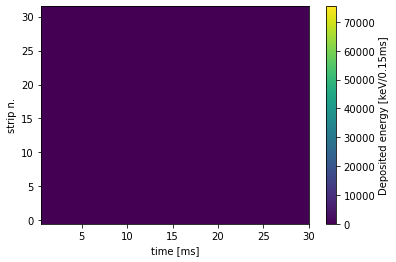

In [9]:
time_btw_frames = acc_time + delay
y_tics = np.arange(0,32,1)
t_tics = np.arange(0, frames.shape[0]*time_btw_frames, time_btw_frames)
t_tics += start_delay

cmap = copy.copy(mp.cm.get_cmap("viridis"))
#bad measeurement in grey
cmap.set_under("grey") 


fig,ax = plt.subplots()
im = ax.pcolormesh(t_tics, y_tics, frames.T, vmin = 0, cmap=cmap, shading = 'auto')
ax.set_ylabel("strip n.")
ax.set_xlabel("time [ms]")

if t_plasma_start != -1.0 and t_plasma_start != -1.0:
    ax.set_xlim(start_delay, t_plasma_end + 2)
    ax.axvline(t_plasma_start, color = "white", dashes=[1, 2], label='plasma start')
    ax.axvline(t_plasma_end, color = "white", dashes=[1, 2], label='plasma end')
else:
    ax.set_xlim(start_delay, 30.0)
cbar = fig.colorbar(im, ax=ax);
if acc_mode == 'hit count':
    cbar.set_label(acc_mode)
elif acc_mode == "ToT":
    cbar.set_label("Deposited energy [keV/{}ms]".format(acc_time))
elif acc_mode == "first hit":
    cbar.set_label("First hit energy [kev]")

fig.savefig('icon-fig.png')